In [1]:
#CTA

In [2]:
suppressPackageStartupMessages({
library(MASS, quietly = TRUE)
library(stringi, quietly = TRUE)
library(dplyr, quietly = TRUE)
library(tidyr, quietly = TRUE)
library(ggplot2, quietly = TRUE)
library(data.table, quietly = TRUE)
library(quanteda, quietly = TRUE)
library(xlsx, quietly = TRUE)
library(stringr, quietly = TRUE)
library(xtable, quietly = TRUE)
    library(mfx, quietly = TRUE)
    library(forcats, quietly = TRUE)
    library(ggalt)
    library(stm)
    })

Warning message:
"Paket 'stringi' wurde unter R Version 4.2.2 erstellt"
Warning message:
"Paket 'dplyr' wurde unter R Version 4.2.3 erstellt"
Warning message:
"Paket 'tidyr' wurde unter R Version 4.2.3 erstellt"
Warning message:
"Paket 'ggplot2' wurde unter R Version 4.2.3 erstellt"
Warning message:
"Paket 'data.table' wurde unter R Version 4.2.3 erstellt"
Warning message:
"Paket 'quanteda' wurde unter R Version 4.2.3 erstellt"
Warning message:
"Paket 'xlsx' wurde unter R Version 4.2.1 erstellt"
Warning message:
"Paket 'stringr' wurde unter R Version 4.2.3 erstellt"
Warning message:
"Paket 'xtable' wurde unter R Version 4.2.1 erstellt"
Warning message:
"Paket 'mfx' wurde unter R Version 4.2.1 erstellt"
Warning message:
"Paket 'sandwich' wurde unter R Version 4.2.1 erstellt"
Warning message:
"Paket 'lmtest' wurde unter R Version 4.2.1 erstellt"
Warning message:
"Paket 'zoo' wurde unter R Version 4.2.3 erstellt"
Warning message:
"Paket 'betareg' wurde unter R Version 4.2.1 erstellt"
Warn

In [3]:
path_data <- ""

df <- read.csv(paste(path_data,'final_anes_metadata.csv',sep=''))
# Convert columns to numeric in R
df$ideology <- as.numeric(df$ideology)
df$pid_summary <- as.numeric(df$pid_summary)

# Filter rows based on conditions
df <- df[df$pid_summary > 0, ]
df <- df[df$pid_summary != 3, ]
df <- df[!is.na(df$pid_summary), ]  # Remove NA values

# Create a new column 'republican'
df$republican <- ifelse(df$pid_summary > 3, 1, 0)

# Assign values to 'text', 'outcome', and 'metadata'
text <- df$mip_1
outcome <- df$republican
metadata <- df[c("miiele1_code1", "mippol1_code1", "age", "female")]


In [8]:
df$nsentence <- ifelse(is.na(text)==F,nsentence(text),NA)
df$nwords <- ifelse(is.na(text)==F,str_count(text, "\\w+"),NA)

Warning message in nsentence.character(text):
"nsentence() does not correctly count sentences in all lower-cased text"


In [9]:
mean(df$nsentence)
median(df$nsentence)
sd(df$nsentence)

[1] 1.00077

[1] 1

[1] 0.02774568

In [10]:
mean(df$nwords)
median(df$nwords)
sd(df$nwords)

[1] 4.103156

[1] 2

[1] 5.900313

In [11]:
nrow(df)

[1] 1299

In [12]:
# Load the necessary libraries
#library(dplyr)
#library(tidytext)
#library(textstem)  # for lemmatization
#library(cleanNLP)  # for POS tagging

library(udpipe)
library(BTM)
library("quanteda")
library("spacyr")

Warning message:
"Paket 'udpipe' wurde unter R Version 4.2.3 erstellt"
Warning message:
"Paket 'BTM' wurde unter R Version 4.2.3 erstellt"
Warning message:
"Paket 'spacyr' wurde unter R Version 4.2.3 erstellt"


In [13]:
anes_lemma <- read.csv(paste(path_data,'cta_data/anes_lemmatized.csv',sep=''))


In [14]:
toks_q <- tokens(anes_lemma$text_lemma,
  remove_punct = TRUE, remove_numbers = TRUE
) %>%
  tokens_tolower()

In [15]:
as.data.frame.tokens <- function(x) {
  data.frame(
    doc_id = rep(names(x), lengths(x)),
#       doc_id = rep(lengths(x)),
    tokens = unlist(x, use.names = FALSE)
  )
}

In [16]:
set.seed(42)
model2 <- BTM(as.data.frame.tokens(toks_q), k = 4, beta = 0.01, iter = 100, trace = 10)

2024-07-28 08:01:29 Start Gibbs sampling iteration 1/100
2024-07-28 08:01:29 Start Gibbs sampling iteration 11/100
2024-07-28 08:01:29 Start Gibbs sampling iteration 21/100
2024-07-28 08:01:29 Start Gibbs sampling iteration 31/100
2024-07-28 08:01:29 Start Gibbs sampling iteration 41/100
2024-07-28 08:01:29 Start Gibbs sampling iteration 51/100
2024-07-28 08:01:29 Start Gibbs sampling iteration 61/100
2024-07-28 08:01:29 Start Gibbs sampling iteration 71/100
2024-07-28 08:01:29 Start Gibbs sampling iteration 81/100
2024-07-28 08:01:29 Start Gibbs sampling iteration 91/100


In [17]:
# Convert to dataframe
df_topic_probabilities <- data.frame(predict(model2, newdata = as.data.frame.tokens(toks_q)))

# Rename the columns
colnames(df_topic_probabilities) <- paste0("topic_", 1:ncol(df_topic_probabilities))

df_topic_probabilities$doc <- rownames(df_topic_probabilities)

# If you want 'doc' to be the first column
df_topic_probabilities <- df_topic_probabilities[, c(ncol(df_topic_probabilities), 1:(ncol(df_topic_probabilities)-1))]
df_topic_probabilities$doc <- as.numeric(gsub("text", "", df_topic_probabilities$doc))
df_topic_probabilities <- df_topic_probabilities[order(df_topic_probabilities$doc), ]
rownames(df_topic_probabilities) <- NULL

In [18]:
write.csv(df_topic_probabilities, 
          paste(path_data,"btm_anes_topic_probabilities.csv",sep=''),
          row.names = FALSE)

In [19]:
# Get top words for each topic
top_words <- terms(model2, top_n = 5)

# Initialize an empty dataframe
df_top_words <- data.frame(matrix(ncol = length(top_words), nrow = 1))

# Fill the dataframe
for (i in 1:length(top_words)) {
  df_top_words[,i] <- paste(top_words[[i]]$token, collapse = ", ")
}

# Rename the columns
colnames(df_top_words) <- paste0("topic_", 1:ncol(df_top_words))


In [20]:
write.csv(df_top_words, 
          paste(path_data,"btm_anes_top_words.csv",sep=''), 
          row.names = FALSE)

In [21]:
df_top_words

topic_1,topic_2,topic_3,topic_4
<chr>,<chr>,<chr>,<chr>
"world, foreign, country, economy, think","economy, money, job, problem, country","people, think, economy, get, go","war, need, iraq, people, job"


In [22]:
#stm

temp<-textProcessor(documents=anes_lemma$text_lemma,metadata=anes_lemma,stem = FALSE)
out <- prepDocuments(temp$documents, temp$vocab, temp$meta)


Building corpus... 
Converting to Lower Case... 
Removing punctuation... 
Removing stopwords... 
Removing numbers... 
Creating Output... 
Removing 376 of 633 terms (376 of 2607 tokens) due to frequency 
Removing 27 Documents with No Words 
Your corpus now has 1266 documents, 257 terms and 2231 tokens.

In [23]:
# help(textProcessor)

In [24]:
set.seed(42)
mod.out <- stm(out$documents, out$vocab, 4,seed=42,
prevalence=~outcome, data=out$meta,max.em.its = 1000)


Beginning Spectral Initialization 
	 Calculating the gram matrix...
	 Finding anchor words...
 	....
	 Recovering initialization...
 	..
Initialization complete.
.........................................................................................................
Completed E-Step (0 seconds). 
Completed M-Step. 
Completing Iteration 1 (approx. per word bound = -4.223) 
.........................................................................................................
Completed E-Step (0 seconds). 
Completed M-Step. 
Model Converged 


In [25]:
summary(mod.out)

A topic model with 4 topics, 1266 documents and a 257 word dictionary.


Topic 1 Top Words:
 	 Highest Prob: donotknow, problem, economy, party, right, healthcare, war 
 	 FREX: problem, party, right, big, corruption, democrats, donotknow 
 	 Lift: corruption, party, problem, big, right, face, cooperation 
 	 Score: problem, party, right, big, corruption, economy, donotknow 
Topic 2 Top Words:
 	 Highest Prob: economy, war, iraq, job, world, money, financial 
 	 FREX: economy, iraq, war, job, financial, terrorist, world 
 	 Lift: division, say, democracy, health, terror, away, start 
 	 Score: economy, war, iraq, job, financial, world, money 
Topic 3 Top Words:
 	 Highest Prob: foreign, terrorism, affair, economy, policy, donotknow, budget 
 	 FREX: foreign, affair, policy, terrorism, oil, like, equality 
 	 Lift: fuel, foreign, oil, dependence, affair, policy, pull 
 	 Score: foreign, affair, policy, economy, terrorism, oil, fuel 
Topic 4 Top Words:
 	 Highest Prob: people, country, economic, deficit, money, need, think 
 	 FREX: people, country, deficit, 

In [26]:
stm_topic_proportions <- as.data.frame(mod.out$theta)
# Get the number of topics
num_topics <- ncol(stm_topic_proportions)

# Create the new column names
new_colnames <- paste0("topic_", 1:num_topics)

# Assign the new column names to the dataframe
colnames(stm_topic_proportions) <- new_colnames


In [35]:
stm_topic_proportions$republican <- out$meta$outcome

In [36]:
write.csv(stm_topic_proportions, 
          paste(path_data,"stm_anes_topic_probabilities.csv",sep=''),
          row.names = FALSE)

In [29]:
# Get the top 5 words for each topic
top_words <- labelTopics(mod.out, n=5)

# Convert the matrix to a dataframe
stm_top_words <- as.data.frame(t(top_words$prob))

# Convert the top words for each topic to a single string, separated by a comma
stm_top_words <- apply(stm_top_words, 2, paste, collapse = ", ")

# Convert the matrix back to a dataframe
stm_top_words <- as.data.frame(t(stm_top_words))

# Assign the new column names to the dataframe
colnames(stm_top_words) <- new_colnames

In [30]:
stm_top_words

topic_1,topic_2,topic_3,topic_4
<chr>,<chr>,<chr>,<chr>
"donotknow, problem, economy, party, right","economy, war, iraq, job, world","foreign, terrorism, affair, economy, policy","people, country, economic, deficit, money"


In [31]:
write.csv(stm_top_words, 
          paste(path_data,"stm_anes_top_words.csv",sep=''), 
          row.names = FALSE)

In [ ]:
# Make plots

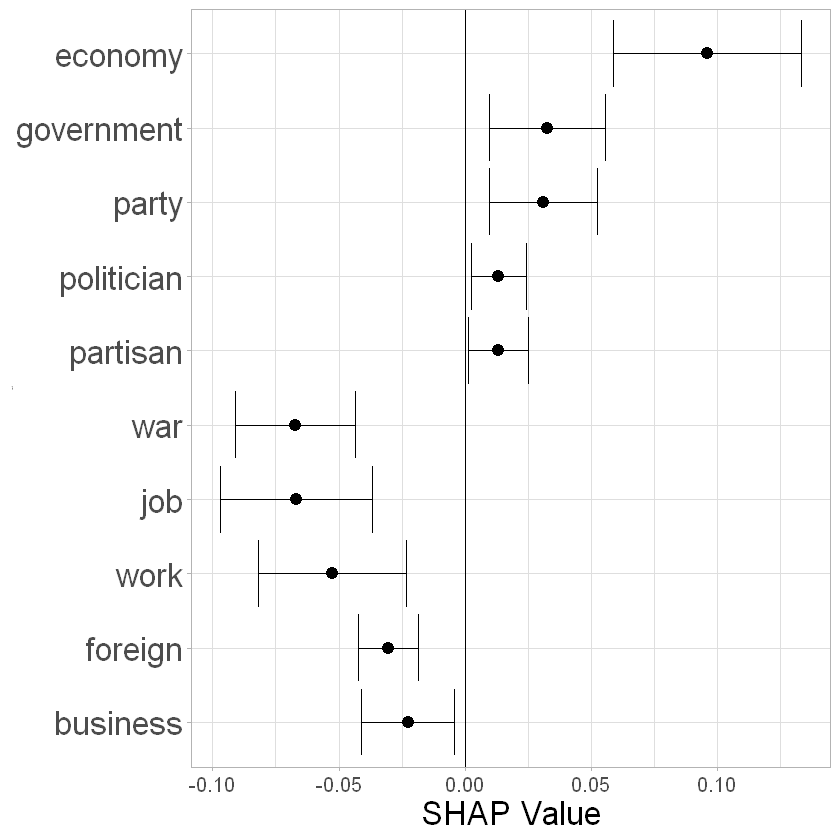

In [4]:
# load X_all
feature_imp <- read.csv(paste(path_data,"cta_data/anes_republican_shap_bert_180824.csv",sep='')
                          ,header = TRUE, sep = ",")

# compute mean and t-val for each word

words_shap <- data.frame(word=colnames(feature_imp))
words_shap$mean <- 0
words_shap$se <- 0
words_shap$t_val <- 0
words_shap$p_val <- 0


for (i in c(1:nrow(words_shap))){
    word_name <- words_shap$word[i]
    shap_col <- feature_imp[,word_name]
#     shap_col <- shap_col[which(shap_col!=0)]
    words_shap$mean[i] <- mean(shap_col)
#     words_shap$median[i] <- median(shap_col)
    words_shap$se[i] <- sd(shap_col)/sqrt(length(shap_col))
    words_shap$t_val[i] <- abs(words_shap$mean[i]/words_shap$se[i])
#     words_shap$t_val[i] <- abs(words_shap$mean[i]/(words_shap$sd[i]))
    words_shap$p_val[i] <- t.test(feature_imp[,word_name])$p.val
}
words_shap$mean_abs <- abs(words_shap$mean)
words_shap <- words_shap[order(-words_shap$mean_abs),]

n_words <- 5
# word_shap_tmp <- words_shap[which(words_shap$mean>0&words_shap$t_val>1.96),]
word_shap_tmp <- words_shap[which(words_shap$mean>0&words_shap$p_val<0.1),]
words_tmp <- word_shap_tmp[1:n_words,'word']
# words_tmp_corr <- word_shap_tmp[1:n_words,'word_corr']

# word_shap_tmp <- words_shap[which(words_shap$mean<0&words_shap$t_val>1.96),]
word_shap_tmp <- words_shap[which(words_shap$mean<0&words_shap$p_val<0.1),]
words_tmp <- c(words_tmp,word_shap_tmp[1:n_words,'word'])
# words_tmp_corr <-  c(words_tmp_corr,word_shap_tmp[1:n_words,'word_corr'])

shap_words_tmp <- feature_imp[,words_tmp]


# reshape as long datafile

index <- 1
for (i in colnames(shap_words_tmp)){
    n_obs <- nrow(shap_words_tmp)
    if(index==1){
        shap_words_tmp_reshape <- data.frame(shap=shap_words_tmp[,index],word=colnames(shap_words_tmp)[index])
    }else{
        tmp_reshape <- data.frame(shap=shap_words_tmp[,index],word=colnames(shap_words_tmp)[index])
        shap_words_tmp_reshape <- rbind(shap_words_tmp_reshape,tmp_reshape)
    }
    index <- index+1
}

# shap_words_tmp_reshape <- shap_words_tmp_reshape[which(shap_words_tmp_reshape$shap!=0),]
shap_words_tmp_reshape$word <- fct_rev(factor(shap_words_tmp_reshape$word , levels=colnames(shap_words_tmp)))

min.mean.sd.max <- function(x) {
  r <- c(t.test(x, conf.level = 0.90)$"conf.int"[1], t.test(x, conf.level = 0.90)$"conf.int"[1], 
         mean(x), t.test(x, conf.level = 0.90)$"conf.int"[2], 
         t.test(x, conf.level = 0.90)$"conf.int"[2])
  names(r) <- c("ymin", "lower", "middle", "upper", "ymax")
  r
}

ggplot(shap_words_tmp_reshape, aes(x = shap, y = word)) + 
  geom_vline(xintercept =0) + 
  theme_light() + 
  xlab("SHAP Value") +
  theme(axis.title.x = element_text(size = 20),
        axis.text.x = element_text(size = 12),
        axis.title.y = element_text(size =0),
        axis.text.y = element_text(size =20)) +
  stat_summary(fun.data = min.mean.sd.max, geom = "errorbar", linewidth=0.5) +
  stat_summary(
    geom = "point",
    fun = "mean",
    col = "black",
    size = 3,
    shape = 21,
    fill = "black"
  )


In [5]:
# Make plots

In [6]:
library(ggalt)

In [7]:
tsne_df_step1 <- read.csv("research_data/cta_bert/tsne_anes_step1.csv", row.names = 1)
tsne_df_step2 <- read.csv("research_data/cta_bert/tsne_anes_step2.csv", row.names = 1)
tsne_df_step3 <- read.csv("research_data/cta_bert/tsne_anes_step3.csv", row.names = 1)


In [10]:
# Define the subset of words and their corresponding groups

cluster_list_groups <- list(c('war', 'crisis', 'terrorist'),
 c('job', 'work', 'way'),
 c('business', 'finance', 'education'),
 c('need', 'want', 'know'))
 

# Assign colors to each group
group_colors <- c('red', 'blue', 'green', 'orange')




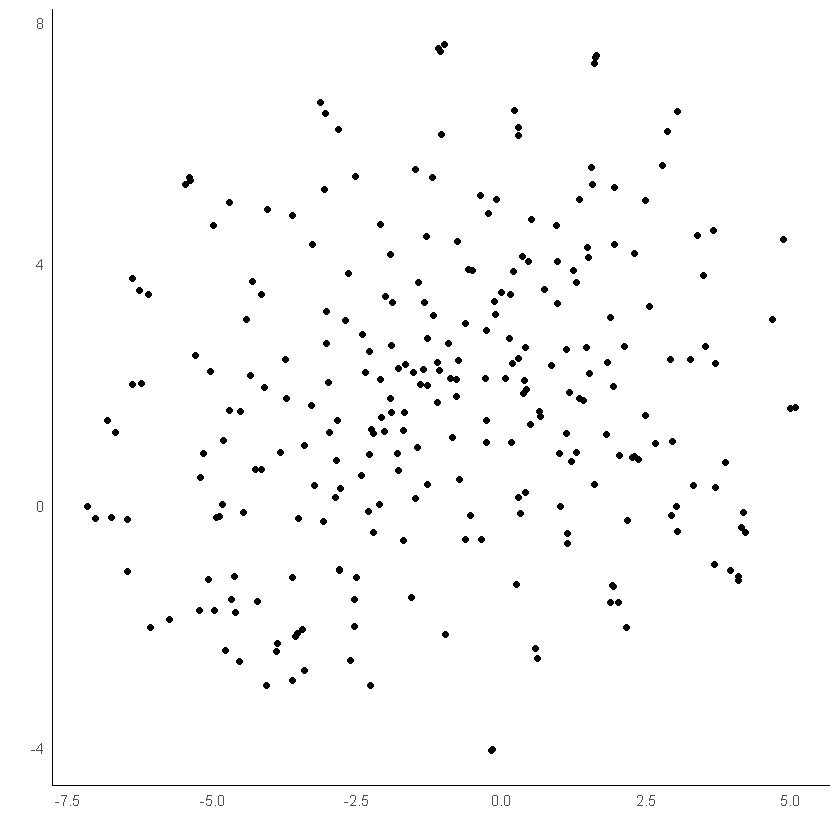

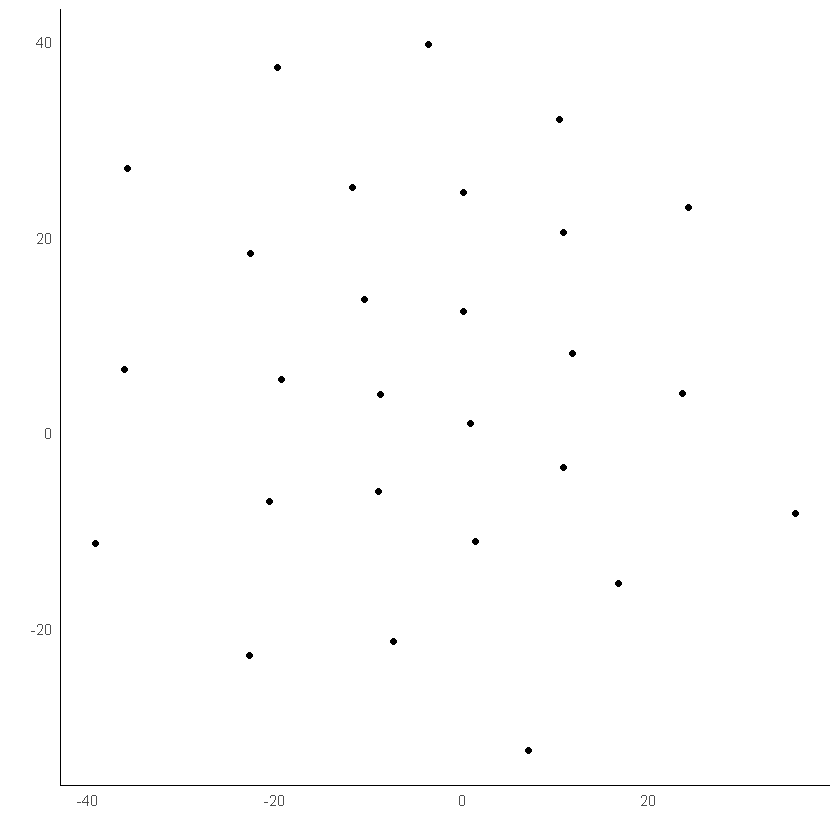

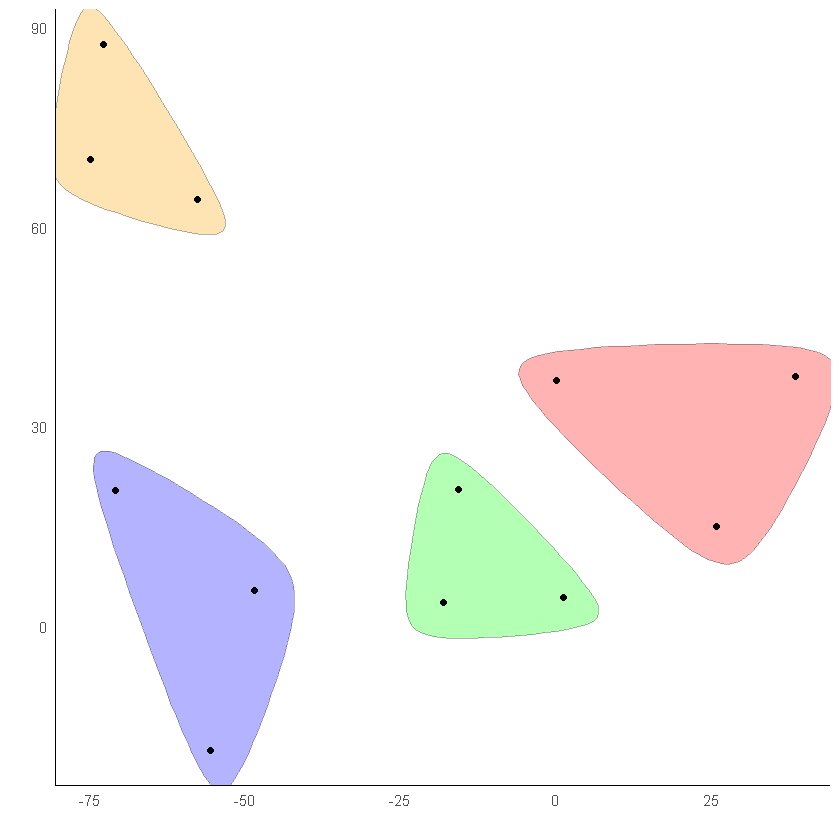

In [11]:
# Plot the word embeddings Step 1
ggplot(tsne_df_step1, aes(X, Y)) +
  geom_point() +
  theme_minimal() +
  labs(x = "", y = "") +
  theme(
    panel.grid = element_blank(),
    axis.line = element_line(color = "black")
  )

# Plot the word embeddings Step 2
ggplot(tsne_df_step2, aes(X, Y)) +
  geom_point() +
  theme_minimal() +
  labs(x = "", y = "") +
  theme(
    panel.grid = element_blank(),
    axis.line = element_line(color = "black")
  )

# Create the base scatter plot
scatter_plot <- ggplot(tsne_df_step3, aes(X, Y)) +
  geom_point(color = group_colors[rep(1:length(cluster_list_groups), sapply(cluster_list_groups, length))],
             show.legend = FALSE) +
  theme_minimal() +
  labs(x = "", y = "") +
  theme(
    panel.grid = element_blank(),
    axis.line = element_line(color = "black")
  )

# Add encircling for each group with colors
encircled_plot <- scatter_plot +
  geom_encircle(data = tsne_df_step3, aes(X, Y, group = rep(1:length(cluster_list_groups), sapply(cluster_list_groups, length))),
                fill = group_colors[rep(1:length(cluster_list_groups), sapply(cluster_list_groups, length))],
                alpha = 0.3, show.legend = FALSE) +
  geom_point(show.legend = FALSE)

# Display the plot
encircled_plot
